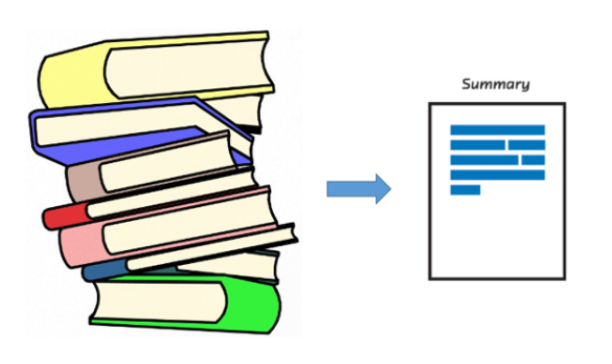

# Text Summarization with Machine Learning

It involves condensing a piece of text into a shorter version, reducing the size of the original text while preserving key information and the meaning of the content. Since manual text synthesis is a long and generally laborious task, task automation is gaining in popularity and therefore a strong motivation for academic research.

In Machine Learning, there are important applications for text summarization in various Natural Language Processing related tasks such as text classification, answering questions, legal text synthesis, news synthesis, and headline generation which can be achieved with Machine Learning. The intention to summarize a text is to create an accurate and fluid summary containing only the main points described in the document.

## Types of Approaches to Summarize Text

Before I dive into showing you how we can summarize text using machine learning and python, it is important to understand what are the types of text summarization to understand how the process works, so that we can use logic while using machine learning techniques to summarize the text.

Generally, Text Summarization is classified into two main types: Extraction Approach and Abstraction Approach. Now let’s go through both these approaches before we dive into the coding part.

## The Extractive Approach

The Extractive approach takes sentences directly from the document according to a scoring function to form a cohesive summary. This method works by identifying the important sections of the text cropping and assembling parts of the content to produce a condensed version.

## The Abstractive Approach

The Abstraction approach aims to produce a summary by interpreting the text using advanced natural language techniques to generate a new, shorter text – parts of which may not appear in the original document, which conveys the most information.

I will use the TextRank algorithm which is an extractive and unsupervised machine learning algorithm for text summarization.

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to C:\Users\Lauro
[nltk_data]     Ribeiro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("tennis.csv")
df.head()

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_id    8 non-null      int64 
 1   article_text  8 non-null      object
 2   source        8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [4]:
df['article_text'][1]

"BASEL, Switzerland (AP), Roger Federer advanced to the 14th Swiss Indoors final of his career by beating seventh-seeded Daniil Medvedev 6-1, 6-4 on Saturday. Seeking a ninth title at his hometown event, and a 99th overall, Federer will play 93th-ranked Marius Copil on Sunday. Federer dominated the 20th-ranked Medvedev and had his first match-point chance to break serve again at 5-1. He then dropped his serve to love, and let another match point slip in Medvedev's next service game by netting a backhand. He clinched on his fourth chance when Medvedev netted from the baseline. Copil upset expectations of a Federer final against Alexander Zverev in a 6-3, 6-7 (6), 6-4 win over the fifth-ranked German in the earlier semifinal. The Romanian aims for a first title after arriving at Basel without a career win over a top-10 opponent. Copil has two after also beating No. 6 Marin Cilic in the second round. Copil fired 26 aces past Zverev and never dropped serve, clinching after 2 1/2 hours with

### I will split the sequences into the data by tokenizing them using a list

In [5]:
from nltk.tokenize import sent_tokenize

sentences = []
for s in df['article_text']:
    sentences.append(sent_tokenize(s))
    
sentences = [y for x in sentences for y in x]

I am going to use the Glove method for word representation, it is an unsupervised learning algorithm developed by Stanford University to generate word integrations by aggregating the global word-to-word co-occurrence matrix from a corpus. 

You can download the file and put it into the same folder: https://www.kaggle.com/danielwillgeorge/glove6b100dtxt

In [6]:
word_embeddings = {}

f= open('glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]"," ")
clean_sentences = [s.lower() for s in clean_sentences]
stop_words = stopwords.words('english')

def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

<ipython-input-6-d630cda9a811>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]"," ")


In [7]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

# Finding Similarities to Summarize Text

The next step is to find similarities between the sentences, and I will use the cosine similarity approach for this task. Let’s create an empty similarity matrix for this task and fill it with cosine similarities of sentences

In [8]:
sim_mat = np.zeros([len(sentences), len(sentences)])

from sklearn.metrics.pairwise import cosine_similarity
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

I am going to convert the sim_mat similarity matrix into the graph, the nodes in this graph will represent the sentences and the edges will represent the similarity scores between the sentences

In [9]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

### Let`s summarize text

In [10]:
ranked_sentences = sorted(((scores[i], s) for i,s in enumerate(sentences)), reverse=True)

for i in range(5):
    print("ARTICLE: ")
    print(df['article_text'][i])
    print("\n")
    print("SUMMARY: ")
    print(ranked_sentences[i][1])
    print("\n")

ARTICLE: 
Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you're in 

### Text summarization system using machine learning  reduces your effort to find important and the most relevant information from any topic